In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
from math import comb
import math
import os
import json
from pathlib import Path
import pickle

In [7]:
num_anchors = 288 #Number of anchors around the circle
line_darkness = 0.3  #Brightness of the center of each line
num_lines = 4000
img_path = "../data/upscaled.png"

In [8]:
def preprocess_image(image_path: str, img_size: int = None):
    """Returns a 2D numpy array with a greyscale, square image
    Args:
        image_path: Path to the image file
        img_size: The target dimensions of the output square image
    Returns:
        img: The numpy 2D array of the image
        new_center: The center of the image
        radius: The radius of the image
    """
    # Load the image in grayscale
    img = Image.open(image_path).convert("L")

    # Normalize the image to [0, 1] and invert so that 1 is dark and 0 is bright
    img = 1 - np.array(img) / 255.0

    # Transpose the image to switch to (x, y) format
    img = img.T

    # Determine the center and radius
    width, height = img.shape
    center = (int(width / 2), int(height / 2))
    radius = min(center[0], center[1])  # Subtract 5 from the radius

    # Create the circular mask
    x, y = np.ogrid[-center[0]:width-center[0], -center[1]:height-center[1]]
    mask = x*x + y*y <= radius*radius

    # Apply the mask
    img = np.multiply(img, mask)

    # Crop the image
    img = img[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius]

    if img_size is not None:
        # Resize the image to pixel_number x pixel_number
        img = Image.fromarray((img * 255).astype(np.uint8))
        img = img.resize((img_size, img_size), Image.ANTIALIAS)
        img = np.array(img) / 255.0

        # The center is now at the middle of the resized image
        center = (int(img_size / 2), int(img_size / 2))
        # Adjusted radius
        radius = center[0]

        # The center is now at the middle of the cropped image
        center = (radius, radius)

    return img, center, radius

In [9]:
def create_anchors(center, radius, num_anchors):
    """Creates a list of tuples, each being the cordinates of an anchor
    Args:
        center: The center of the image
        radius: The radius of the image (1/2 of the width)
        num_anchors: The number of the anchors around the image
    """
    # Calculate the coordinates of the anchor points
    angles = np.linspace(0, 2*np.pi, num_anchors, endpoint=False)
    anchor_x = np.round(center[0] + (radius - 1) * np.cos(angles)).astype(int)
    anchor_y = np.round(center[1] + (radius - 1) * np.sin(angles)).astype(int)
    anchors = list(zip(anchor_x, anchor_y))
    
    return anchors

In [10]:
def create_circle_mask(center, radius, shape):
    """Create a boolean mask for a circle to make sure that we don't add pixels outside of the circle boundaries when drawing the lines"""
    x = np.arange(0, shape[1])[None, :]
    y = np.arange(0, shape[0])[:, None]
    mask = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2

    return mask

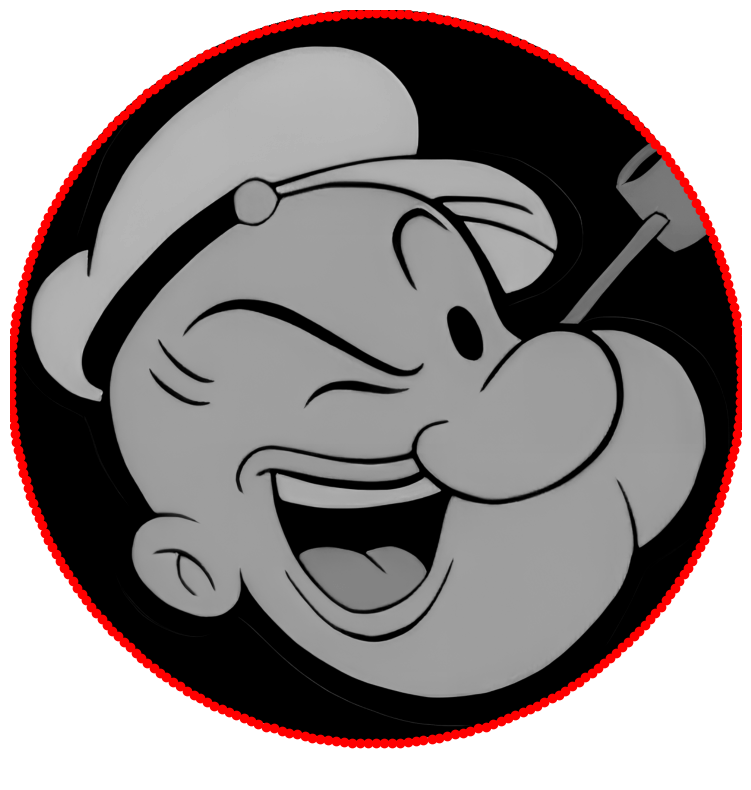

In [11]:
# Preprocess image
img, center, radius = preprocess_image(img_path)

# Create anchors
anchors = create_anchors(center, radius, num_anchors)

mask = create_circle_mask(center, radius, img.shape)

plt.figure(figsize=(10, 10))  
plt.imshow(img.T, cmap='gray_r')
anchors_x, anchors_y = zip(*anchors)
plt.scatter(anchors_x, anchors_y, color='red')
plt.axis('off')
plt.show()

In [12]:
def draw_line(p0: tuple, p1: tuple, multiplier: float, mask):
    """Creates a dictionary of coordinates and their darkness values of a line between two points. Uses Xiaolin Wu’s anti-aliasing algorithm
    Args: 
        p0: The first coordinate for the line
        p1: The second cordinate for the line
        multiplier: The darkness value that gets multiplied by each pixel
        mask: The boolean mask for a circle
    Returns:
        A dictionary of each pixel in the line and their darkness value
    """
    x0, y0 = p0
    x1, y1 = p1
    pixel_list = []
    darkness_list = []
    steep = abs(y1 - y0) > abs(x1 - x0)
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1

    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0

    dx = x1 - x0
    dy = y1 - y0
    gradient = dy / dx if dx != 0 else 1

    # handle first endpoint (pixel) placement
    xend = round(x0)
    yend = y0 + gradient * (xend - x0)
    xgap = 1 - ((x0 + 0.5) % 1)
    xpxl1 = xend
    ypxl1 = int(yend)
    if steep:
        try:
            if mask[ypxl1, xpxl1]:
                pixel_list.append((ypxl1, xpxl1))
                darkness_list.append(xgap * (1 - (yend % 1)) * multiplier)
        except IndexError:
            pass
        try:
            if mask[ypxl1+1, xpxl1]:
                pixel_list.append((ypxl1+1, xpxl1))
                darkness_list.append(xgap * (yend % 1) * multiplier)
        except IndexError:
            pass
    else:
        try:
            if mask[xpxl1, ypxl1]:
                pixel_list.append((xpxl1, ypxl1))
                darkness_list.append(xgap * (1 - (yend % 1)) * multiplier)
        except IndexError:
            pass
        try:
            if mask[xpxl1, ypxl1+1]:
                pixel_list.append((xpxl1, ypxl1+1))
                darkness_list.append(xgap * (yend % 1) * multiplier)
        except IndexError:
            pass
    intery = yend + gradient

    # handle second endpoint
    xend = round(x1)
    yend = y1 + gradient * (xend - x1)
    xgap = (x1 + 0.5) % 1
    xpxl2 = xend
    ypxl2 = int(yend)
    if steep:
        try:
            if mask[ypxl2, xpxl2]:
                pixel_list.append((ypxl2, xpxl2))
                darkness_list.append(xgap * (1 - (yend % 1)) * multiplier)
        except IndexError:
            pass
        try:
            if mask[ypxl2+1, xpxl2]:
                pixel_list.append((ypxl2+1, xpxl2))
                darkness_list.append(xgap * (yend % 1) * multiplier)
        except IndexError:
            pass
    else:
        try:
            if mask[xpxl2, ypxl2]:
                pixel_list.append((xpxl2, ypxl2))
                darkness_list.append(xgap * (1 - (yend % 1)) * multiplier)
        except IndexError:
            pass
        try:
            if mask[xpxl2, ypxl2+1]:
                pixel_list.append((xpxl2, ypxl2+1))
                darkness_list.append(xgap * (yend % 1) * multiplier)
        except IndexError:
            pass

    # main loop
    for x in range(int(xpxl1 + 1), int(xpxl2)):
        if steep:
            try:
                if mask[int(intery), x]:
                    pixel_list.append((int(intery), x))
                    darkness_list.append((1 - (intery % 1)) * multiplier)
            except IndexError:
                pass
            try:
                if mask[int(intery)+1, x]:
                    pixel_list.append((int(intery)+1, x))
                    darkness_list.append((intery % 1) * multiplier)
            except IndexError:
                pass
        else:
            try:
                if mask[x, int(intery)]:
                    pixel_list.append((x, int(intery)))
                    darkness_list.append((1 - (intery % 1)) * multiplier)
            except IndexError:
                pass
            try:
                if mask[x, int(intery)+1]:
                    pixel_list.append((x, int(intery)+1))
                    darkness_list.append((intery % 1) * multiplier)
            except IndexError:
                pass
        intery += gradient
    return np.array(pixel_list), np.array(darkness_list)

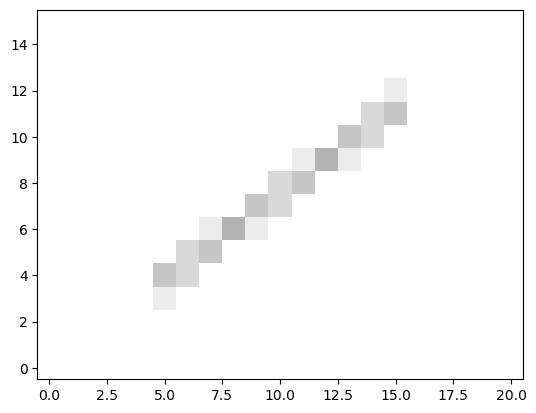

In [13]:
def test_line(p1, p2):
    # Get the maximum coordinates to determine image size
    max_x = max(p1[0], p2[0])
    max_y = max(p1[1], p2[1])
    
    # Create an empty image
    temp_img = np.zeros((max_x + 1, max_y + 1))
    
    temp_mask = create_circle_mask((int(temp_img.shape[0]/2), int(temp_img.shape[1]/2)), min([int(temp_img.shape[0]/2), int(temp_img.shape[1]/2)]), img.shape)
    temp_line_pixels, temp_line_darkness = draw_line(p1, p2, line_darkness, temp_mask)
    # Set the pixel values
    for pixel, darkness in zip(temp_line_pixels, temp_line_darkness):
        temp_img[tuple(pixel)] = darkness

    # Display the image
    plt.imshow(temp_img.T, cmap='gray_r', origin='lower', vmin=0, vmax=1)
    plt.show()

# Test the function
p1 = (0, 0)
p2 = (20, 15)
test_line(p1, p2)

In [14]:
def generate_all_lines(start_anchor):
    """Generates all lines between one anchor and all other anchors. Only used for benchmarking"""
    line_pixel_list = {}
    line_darkness_list = {}
    for end_anchor in anchors:
        if end_anchor is not start_anchor:
            both_anchors = tuple(sorted((start_anchor, end_anchor)))
            if both_anchors not in line_pixel_list:
                pixel_list, darkness_list = draw_line(both_anchors[0], both_anchors[1], line_darkness, mask)
                line_pixel_list[both_anchors] = pixel_list
                line_darkness_list[both_anchors] = darkness_list
    return line_pixel_list, line_darkness_list

In [15]:
#benchmark
start_time = time.perf_counter()
benchmark = generate_all_lines(anchors[0])
print(f"Starting Benchmark")
run_time = (time.perf_counter() - start_time)*1000
estimated_total_time = run_time*(comb(num_anchors, 2)/num_anchors)
print(f"Done! Generated {len(benchmark)} anchor lines on a canvas of size of {radius*2} in {round(run_time, 1)} milliseconds. Estimated time for generating line dict about {round(estimated_total_time/1000, 1)} seconds")

Starting Benchmark
Done! Generated 2 anchor lines on a canvas of size of 1232 in 315.1 milliseconds. Estimated time for generating line dict about 45.2 seconds


In [16]:
def is_within_range(arr, idx1, idx2, x):
    # Calculate the distance between indices in both directions considering wrapped boundaries
    forward_distance = (idx2 - idx1) % len(arr)
    backward_distance = (idx1 - idx2) % len(arr)

    # Check if either forward or backward distance is less than or equal to x
    return forward_distance <= x or backward_distance <= x or idx1 == idx2

In [17]:
def make_line_dict(anchors):
    """Makes a dictionary of every pixel and its darkness value for each line for every possible combination of anchors"""
    line_pixel_dict = {}
    line_darkness_dict = {}
    for start_index, start_anchor in enumerate(tqdm(anchors, desc="Creating Lines")):
        for end_index, end_anchor in enumerate(anchors):
            if is_within_range(anchors, start_index, end_index, 10): continue #You cant make a line between two of the same anchors
            both_anchors = tuple(sorted((start_anchor, end_anchor))) #Sorts the indices for the lines.
            if both_anchors not in line_pixel_dict: #Makes sure that the anchors aren't already in the dictionary, only in a different order. This makes the number of lines needed n choose 2.
                pixel_list, darkness_list = draw_line(both_anchors[0], both_anchors[1], line_darkness, mask) #Draws the line
                line_pixel_dict[both_anchors] = pixel_list
                line_darkness_dict[both_anchors] = darkness_list
    return line_pixel_dict, line_darkness_dict

In [18]:
start_time = start_time = time.perf_counter()
line_pixel_dict, line_darkness_dict = make_line_dict(anchors=anchors)
line_generation_time = time.perf_counter() - start_time

Creating Lines:   0%|          | 0/288 [00:00<?, ?it/s]

In [19]:
def difference(pixel1, pixel2):
    """Calculate the absolute difference between two pixel values."""
    return np.abs(np.subtract(pixel1, pixel2))

In [20]:
def create_string_art_dict(image):
    """Creates a dictionary of pixels inside of the circle, and sets them equal to 0. This will be updated for every added string."""
    string_art_img = np.zeros(image.shape)
    return string_art_img

In [21]:
def create_difference_dict(image):
    """Creates a dictionary of pixels inside of the circle, and sets them equal to the values of the original image. This difference dictionary is used to save the differences between the string_art_dict and the  original image"""
    height, width = image.shape
    difference_img = np.zeros((height, width))
    for y in range(height):
        for x in range(width):
            if mask[x, y]:
                difference_img[x, y] = difference(0, image[x, y])
                
    return difference_img

In [22]:
difference_dict = create_difference_dict(img)
string_art_dict = create_string_art_dict(img)

In [23]:
def find_new_loss(string_pixels, string_values):
    """
    Finds the loss of a single string using numpy arrays.

    string_pixels: A numpy array where each row represents the (x, y) coordinates of a pixel.
    string_values: A numpy array where each entry represents the darkness of the corresponding pixel in string_pixels.
    """
    # Split the string_pixels into separate x and y arrays
    x_coords = string_pixels[:, 0]
    y_coords = string_pixels[:, 1]

    string_art_values = string_art_dict[x_coords, y_coords]
    img_values = img[x_coords, y_coords]
    diff_values = difference_dict[x_coords, y_coords]

    total_values = string_art_values + string_values
    #total_values = np.clip(total_values, 0, 1)  # Ensure that values are in the range [0, 1]
    
    loss = np.sum(difference(img_values, total_values) - diff_values)/len(string_pixels)

    return loss


In [24]:
def find_best_line(start_anchor):
    """Starts at a specified anchor and find the loss for every string leading to every other anchor, updating the best loss whenever a better one is found"""
    best_loss = np.inf #TODO set this to the starting loss and make the algorithm terminate when there isn't a possible improvement
    best_anchors = None #Also saves the set of anchors
    best_end_anchor = None
    for end_anchor in range(len(anchors)):
        both_anchors = tuple(sorted((anchors[start_anchor], anchors[end_anchor]))) #Makes sure to get the right order for the indices, set in make_line_dict().
        if both_anchors not in line_pixel_dict: continue
        temp_loss = find_new_loss(line_pixel_dict[both_anchors], line_darkness_dict[both_anchors]) #Finds the loss of that string
        if(temp_loss < best_loss): #Check if the loss is better
            best_loss = temp_loss
            best_anchors = both_anchors
            best_end_anchor = end_anchor
    return best_loss, best_anchors, best_end_anchor

In [25]:
#benchmark
start_time = time.perf_counter()
benchmark = find_best_line(start_anchor=0)
print(f"Starting Benchmark")
run_time = (time.perf_counter() - start_time)*1000
estimated_total_time = run_time*num_lines
print(f"Done! Found the best line out of {len(anchors)-1} anchors lines on a canvas of size of {img.shape[0]}x{img.shape[0]} in {round(run_time, 1)} milliseconds. Estimated time for finding all lines is {round(estimated_total_time/1000, 1)} seconds")

Starting Benchmark
Done! Found the best line out of 287 anchors lines on a canvas of size of 1232x1232 in 27.2 milliseconds. Estimated time for finding all lines is 108.6 seconds


In [26]:
def update_with_best_line(best_anchors, difference_dict, string_art_dict):
    """Updates the overall loss value, string_art_dict pixels, and difference_dict pixels after finding the best line"""
    
    # Draw the line and get the pixel locations and values
    line_pixels, line_values = draw_line(best_anchors[0], best_anchors[1], line_darkness, mask)
    
    # Split the line_pixels into separate x and y arrays
    x_coords = line_pixels[:, 0]
    y_coords = line_pixels[:, 1]
    
    # Update the string_art_dict using the pixel locations and values
    new_values = np.clip(string_art_dict[x_coords, y_coords] + line_values, 0, 1)
    string_art_dict[x_coords, y_coords] = new_values
    
    # Update the difference_dict with the new differences
    difference_dict[x_coords, y_coords] = difference(img[x_coords, y_coords], new_values)
    
    return string_art_dict, difference_dict


In [27]:
start_time = time.perf_counter()
current_anchor = 0
anchor_list = [current_anchor]
for i in tqdm(range(num_lines), desc="Drawing Lines"):
    best_loss, best_anchors, current_anchor = find_best_line(current_anchor)
    string_art_dict, difference_dict = update_with_best_line(best_anchors, difference_dict, string_art_dict)
    anchor_list.append(current_anchor)
string_art_time = start_time = time.perf_counter() - start_time

Drawing Lines:   0%|          | 0/4000 [00:00<?, ?it/s]

In [28]:
total_time = round(string_art_time + line_generation_time, 1)
end_loss = np.sum(difference_dict)

In [29]:
print(anchor_list)

[0, 70, 81, 92, 81, 92, 104, 116, 104, 116, 100, 112, 124, 135, 124, 135, 149, 135, 149, 136, 147, 136, 147, 161, 150, 134, 150, 134, 121, 109, 97, 109, 96, 108, 122, 110, 122, 94, 106, 89, 101, 89, 78, 66, 78, 93, 123, 93, 78, 93, 80, 93, 73, 84, 96, 116, 128, 116, 131, 142, 153, 126, 107, 121, 95, 109, 90, 126, 153, 166, 153, 170, 153, 127, 115, 101, 131, 152, 131, 151, 132, 151, 112, 155, 166, 129, 179, 151, 103, 118, 130, 163, 174, 156, 115, 97, 78, 137, 161, 133, 160, 173, 186, 173, 161, 134, 159, 175, 133, 83, 120, 90, 126, 97, 69, 93, 114, 102, 152, 172, 187, 172, 147, 71, 120, 154, 125, 185, 78, 140, 72, 100, 68, 108, 76, 95, 74, 85, 140, 66, 6, 68, 0, 73, 126, 172, 133, 278, 82, 116, 155, 187, 160, 199, 157, 190, 156, 134, 158, 201, 113, 143, 72, 127, 89, 220, 69, 101, 2, 68, 1, 125, 183, 152, 178, 166, 193, 165, 131, 76, 142, 93, 134, 104, 143, 79, 65, 7, 66, 120, 78, 127, 82, 227, 1, 86, 137, 92, 130, 81, 246, 1, 216, 1, 99, 70, 116, 201, 118, 73, 146, 94, 254, 85, 255, 0, 2

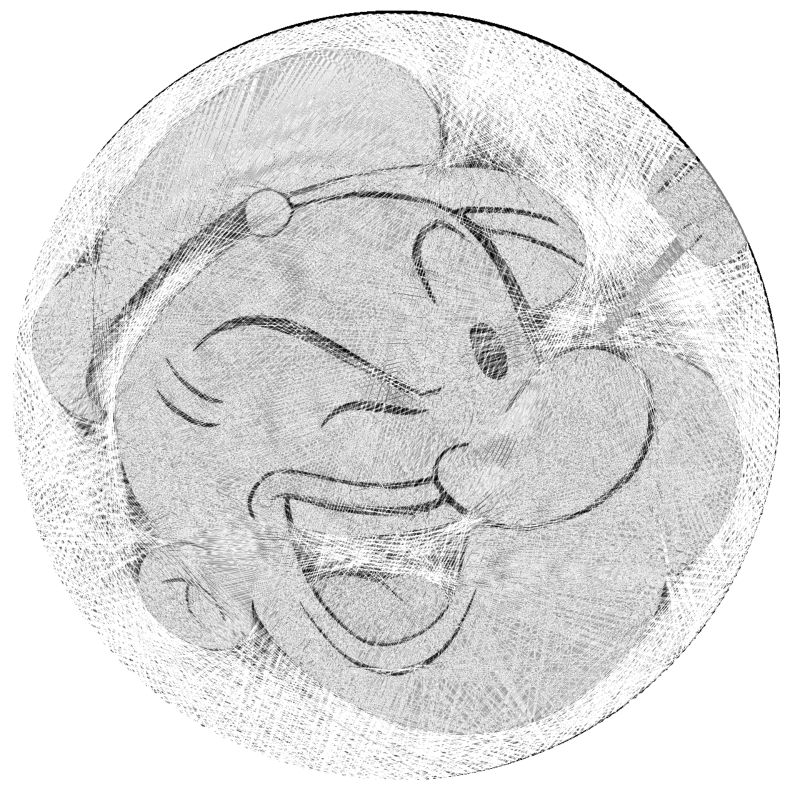

In [30]:
# Create a blank white canvas
diff_canvas = difference_dict

# Show the canvas
plt.figure(figsize=(10, 10))
plt.imshow(diff_canvas.T, cmap='gray_r', vmin=0, vmax=1)
plt.axis('off')
plt.show()

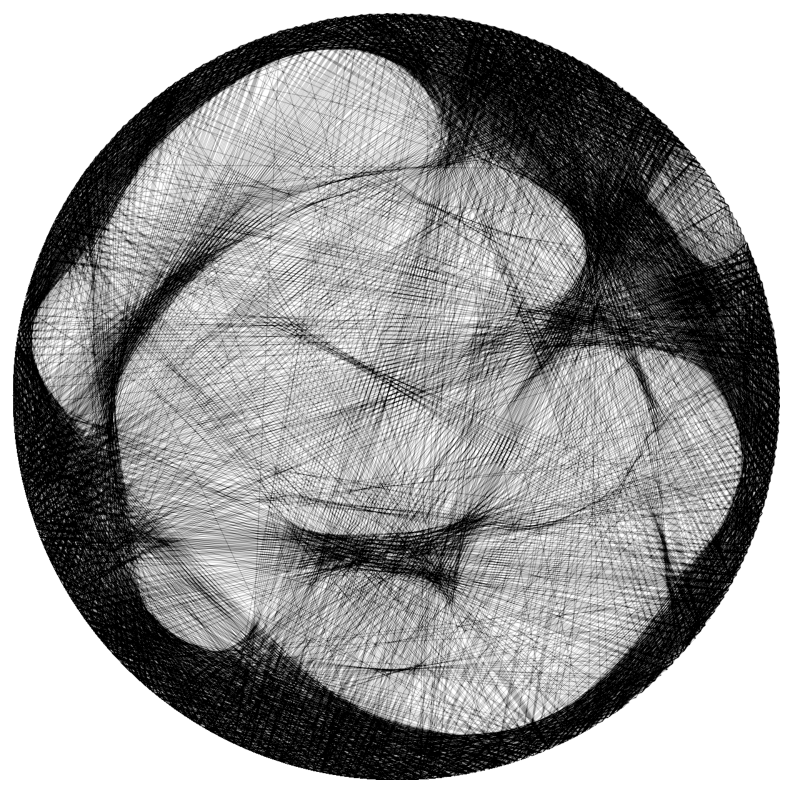

In [31]:
# Create a blank white canvas
string_canvas = string_art_dict

# Show the canvas
plt.figure(figsize=(10, 10))
plt.imshow(string_canvas.T, cmap='gray_r', vmin=0, vmax=1)
plt.axis('off')
plt.show()

In [36]:
def save_data(difference_dict, string_art_dict, directory):
    """
    Saves the given numpy arrays as JPG images in the specified directory.
    
    difference_dict: 2D numpy array representing the difference image.
    string_art_dict: 2D numpy array representing the string art image.
    directory: Path to the directory where images will be saved.
    """

    def save_image(image, directory, name):
        image_data = (1-np.transpose(image))*255
        image = Image.fromarray(image_data.astype(np.uint8))
        image.save(f"{directory}/{name}")
    
    # Check if directory exists; if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    save_image(difference_dict, directory, "difference_image.jpg")
    save_image(string_art_dict, directory, "string_art.jpg")
    save_image(img, directory, "original.jpg")

    config = {
        "num_anchors": num_anchors,
        "num_lines": num_lines,
        "line_darkness": line_darkness,
        "img_shape": img.shape,
        "total_time": total_time,
        "final_loss": end_loss
    }

    config_file = Path(f"{directory}/config.json")
    config_file.write_text(json.dumps(config, indent=2))
    with open(f"{directory}/all_strings.pkl", 'wb') as file:
        pickle.dump(anchor_list, file)
    with open(f"{directory}/all_anchors.pkl", 'wb') as file:
        pickle.dump(anchors, file)

In [37]:
img_dir = "using_min"
save_data(difference_dict, string_art_dict, img_dir)